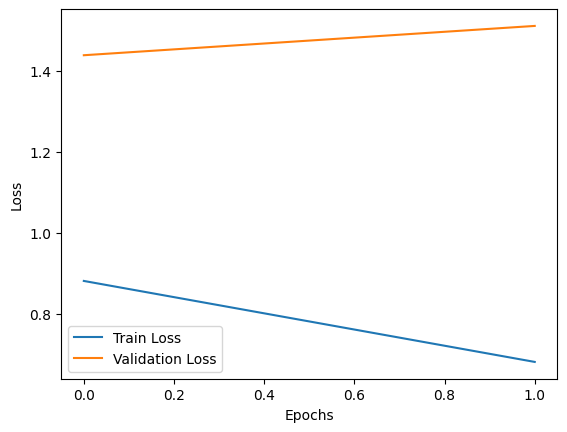

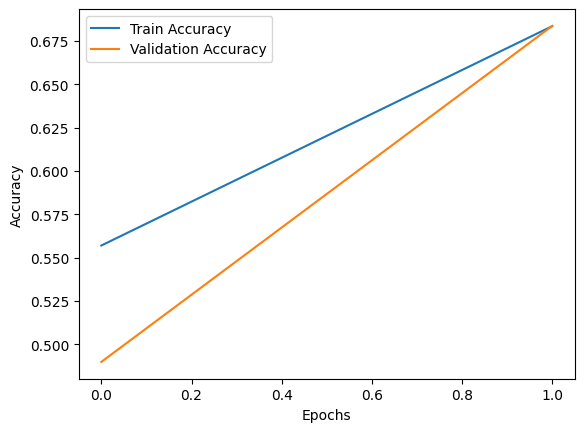

Final Train Loss: 0.6821
Final Validation Loss: 1.5102
Final Train Accuracy: 0.6835
Final Validation Accuracy: 0.6837


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import time

# Step 1: Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Step 2: Define the data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Reduce image size to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # MobileNet normalization
])

# Step 3: Load the Dataset
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)

# Use only 5% of the dataset for training to limit time
train_size = int(0.20 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Smaller batch size to speed up

val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Step 4: Load Pre-trained MobileNet Model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier to match the number of output classes (2: Accident, Non Accident)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 6: Train the Model with a Time Constraint
num_epochs = 2  # Reduce the number of epochs
train_loss, val_loss = [], []
train_acc, val_acc = [], []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        if time.time() - start_time > 60:  # Stop if training time exceeds 1 minute
            break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / len(train_loader.dataset))

    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    val_loss.append(val_running_loss / len(val_loader))
    val_acc.append(val_correct / len(val_loader.dataset))

    if time.time() - start_time > 60:  # Stop if training time exceeds 1 minute
        break

# Step 7: Save the Model
torch.save(model.state_dict(), '/content/drive/MyDrive/mobilenet_train_limited.pth')

# Step 8: Plot Accuracy and Loss Curves
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print final accuracy and loss values
print(f"Final Train Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Train Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


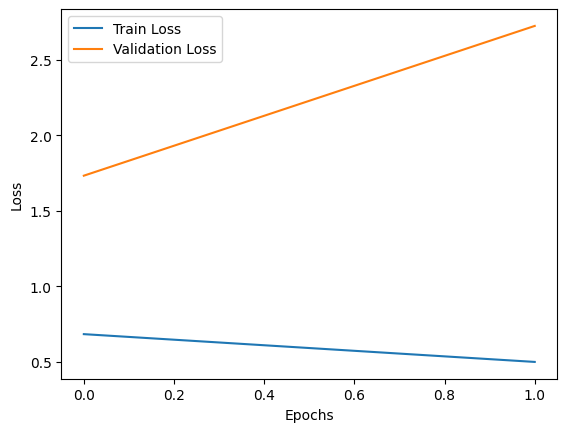

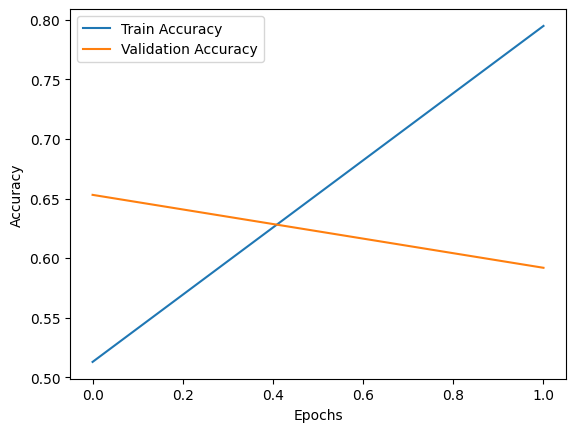

Final Train Loss: 0.4982
Final Validation Loss: 2.7239
Final Train Accuracy: 0.7949
Final Validation Accuracy: 0.5918


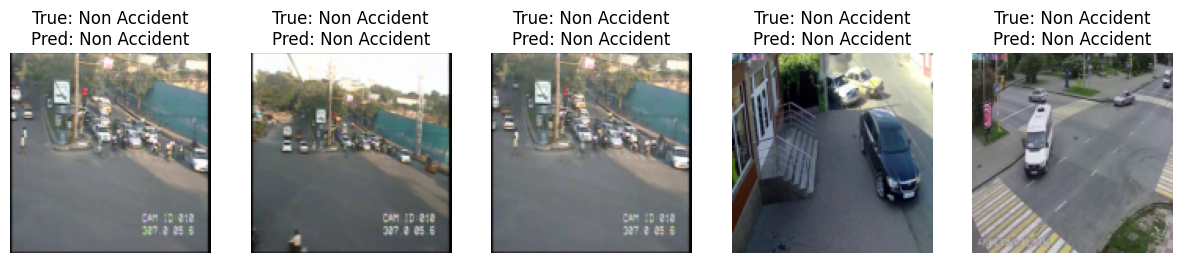

Classification Report:
               precision    recall  f1-score   support

Non Accident       0.57      0.88      0.70        52
    Accident       0.67      0.26      0.38        46

    accuracy                           0.59        98
   macro avg       0.62      0.57      0.54        98
weighted avg       0.62      0.59      0.55        98



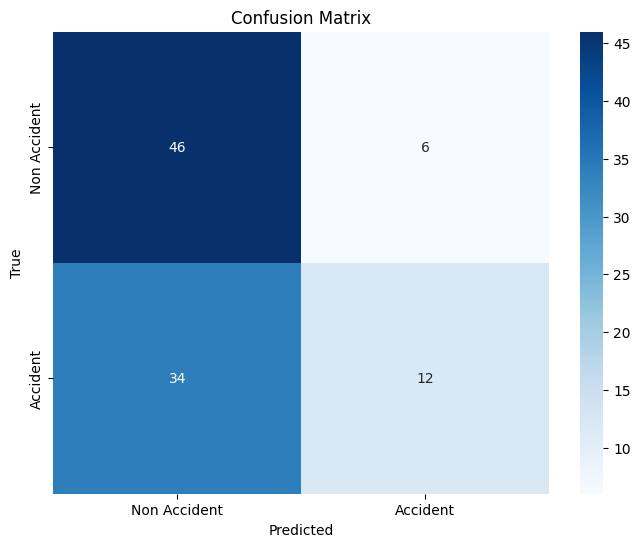

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Step 1: Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Step 2: Define the data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Reduce image size to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # MobileNet normalization
])

# Step 3: Load the Dataset
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)

# Use only 5% of the dataset for training to limit time
train_size = int(0.05 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Smaller batch size to speed up

val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Step 4: Load Pre-trained MobileNet Model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier to match the number of output classes (2: Accident, Non Accident)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 6: Train the Model with a Time Constraint
num_epochs = 2  # Reduce the number of epochs
train_loss, val_loss = [], []
train_acc, val_acc = [], []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        if time.time() - start_time > 60:  # Stop if training time exceeds 1 minute
            break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / len(train_loader.dataset))

    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    val_loss.append(val_running_loss / len(val_loader))
    val_acc.append(val_correct / len(val_loader.dataset))

    if time.time() - start_time > 60:  # Stop if training time exceeds 1 minute
        break

# Step 7: Save the Model
torch.save(model.state_dict(), '/content/drive/MyDrive/mobilenet_train_limited.pth')

# Step 8: Plot Accuracy and Loss Curves
plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print final accuracy and loss values
print(f"Final Train Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Train Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

# Step 9: Generate Predictions on the Validation Set
all_preds = []
all_labels = []
images = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        preds = torch.round(torch.sigmoid(outputs))
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        images.extend(inputs.cpu().numpy())

# Step 10: Display a Few Validation Images with Predictions
num_images_to_show = 5
plt.figure(figsize=(15, 5))
for i in range(num_images_to_show):
    img = np.transpose(images[i], (1, 2, 0))  # Convert to HWC format
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # De-normalize
    img = np.clip(img, 0, 1)
    label = "Accident" if all_labels[i] == 1 else "Non Accident"
    pred_label = "Accident" if all_preds[i] == 1 else "Non Accident"
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(f"True: {label}\nPred: {pred_label}")
    plt.axis('off')
plt.show()

# Step 11: Classification Report and Confusion Matrix
report = classification_report(all_labels, all_preds, target_names=['Non Accident', 'Accident'])
print("Classification Report:\n", report)

cm = confusion_matrix(all_labels, all_preds)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non Accident', 'Accident'], yticklabels=['Non Accident', 'Accident'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


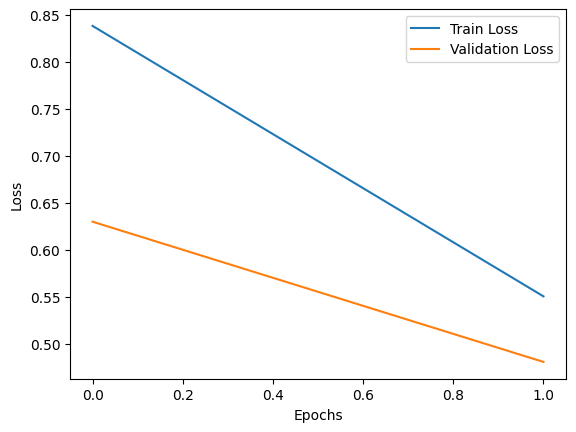

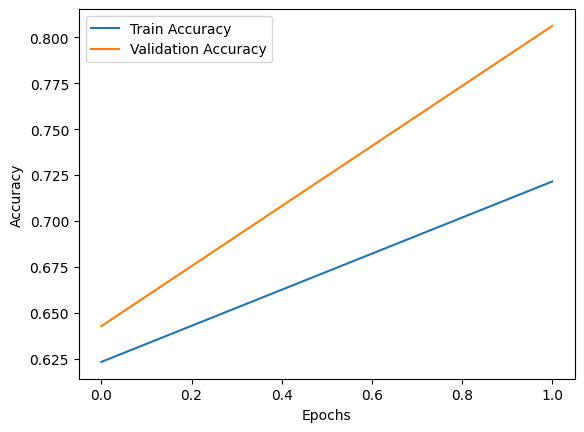

Final Train Loss: 0.5503
Final Validation Loss: 0.4805
Final Train Accuracy: 0.7215
Final Validation Accuracy: 0.8061


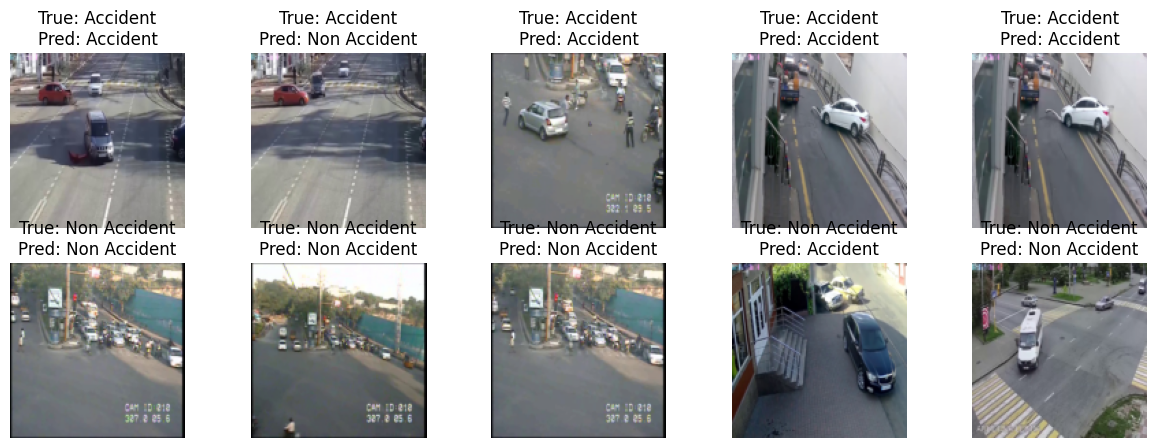

Classification Report:
               precision    recall  f1-score   support

Non Accident       0.88      0.73      0.80        52
    Accident       0.75      0.89      0.81        46

    accuracy                           0.81        98
   macro avg       0.81      0.81      0.81        98
weighted avg       0.82      0.81      0.81        98



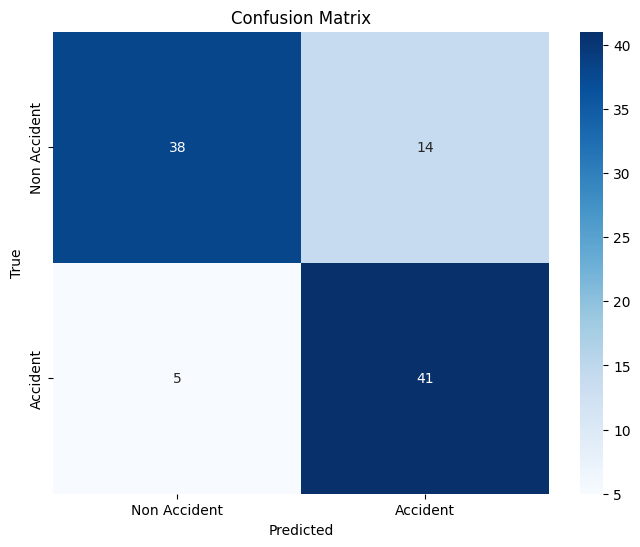

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Step 1: Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Step 2: Define the data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Reduce image size to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # MobileNet normalization
])

# Step 3: Load the Dataset
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)

# Use only 5% of the dataset for training to limit time
train_size = int(0.4 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Smaller batch size to speed up

val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Step 4: Load Pre-trained MobileNet Model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier to match the number of output classes (2: Accident, Non Accident)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 6: Train the Model with a Time Constraint
num_epochs = 2  # Reduce the number of epochs
train_loss, val_loss = [], []
train_acc, val_acc = [], []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        if time.time() - start_time > 60:  # Stop if training time exceeds 1 minute
            break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / len(train_loader.dataset))

    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    val_loss.append(val_running_loss / len(val_loader))
    val_acc.append(val_correct / len(val_loader.dataset))

    if time.time() - start_time > 60:  # Stop if training time exceeds 1 minute
        break

# Step 7: Save the Model
torch.save(model.state_dict(), '/content/drive/MyDrive/mobilenet_train_limited.pth')

# Step 8: Plot Accuracy and Loss Curves
plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print final accuracy and loss values
print(f"Final Train Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Train Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

# Step 9: Generate Predictions on the Validation Set
all_preds = []
all_labels = []
images = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        preds = torch.round(torch.sigmoid(outputs))
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        images.extend(inputs.cpu().numpy())

# Step 10: Display a Mix of Accident and Non-Accident Images
accident_images = []
non_accident_images = []
accident_labels = []
non_accident_labels = []
accident_preds = []
non_accident_preds = []

for i in range(len(all_labels)):
    if all_labels[i] == 1 and len(accident_images) < 5:
        accident_images.append(images[i])
        accident_labels.append(all_labels[i])
        accident_preds.append(all_preds[i])
    elif all_labels[i] == 0 and len(non_accident_images) < 5:
        non_accident_images.append(images[i])
        non_accident_labels.append(all_labels[i])
        non_accident_preds.append(all_preds[i])
    if len(accident_images) >= 5 and len(non_accident_images) >= 5:
        break

# Combine the selected images and labels
selected_images = accident_images + non_accident_images
selected_labels = accident_labels + non_accident_labels
selected_preds = accident_preds + non_accident_preds

# Plot the selected images
plt.figure(figsize=(15, 5))
for i in range(len(selected_images)):
    img = np.transpose(selected_images[i], (1, 2, 0))  # Convert to HWC format
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # De-normalize
    img = np.clip(img, 0, 1)
    label = "Accident" if selected_labels[i] == 1 else "Non Accident"
    pred_label = "Accident" if selected_preds[i] == 1 else "Non Accident"
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {label}\nPred: {pred_label}")
    plt.axis('off')
plt.show()

# Step 11: Classification Report and Confusion Matrix
report = classification_report(all_labels, all_preds, target_names=['Non Accident', 'Accident'])
print("Classification Report:\n", report)

cm = confusion_matrix(all_labels, all_preds)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non Accident', 'Accident'], yticklabels=['Non Accident', 'Accident'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
